# Random Projection on PYNQ-Z1
### Introduction:

This example performs dimensionality reduction via random projection on the PYNQ-Z1. In a random projection, the original m-dimensional data are projected to a lower k-dimensional space via a single multiplication of a randomly generated matrix $W_{m\times k}$.

$$X_{n\times k}^{new}=X_{n\times m}W_{m\times k}$$

Surprisingly, random mappings are capable of maintaining the pair-wise distances of points in the original high dimensional space. This finding is a key result of the **Johnson-Lindenstrauss lemma**. The elements $r_{ij}$ of $R$ are often chosen as Gaussian distributed, but for streaming applications or massively high-dimensional problems, simpler distributions may be preferred such as the one given below:


$$
r_{ij} = \sqrt{\frac{s}{k}} \times \begin{cases} 
      1  \:\:\:\:\: with \: prob. \:\:\: 1/(2s)\\
      0  \:\:\:\:\: with \: prob. \:\:\: (1 - 1/s)\\
      -1 \:\:\:\:\: with \: prob. \:\:\: 1/(2s)
   \end{cases}
$$


This distribution also defines the implementation of **sklearn.random_projection.SparseRandomProjection**, where s refers to the density or sparsity of the matrix. Our version is similar, except we fix s=1 and thus every entry is either +1 or -1. We call this a binary random projection.

A binary random projection is highly amenable to a hardware implementation. This is because the majority of operations involve only addition and subtraction (multiplication of the scaling term is elementwise on the output), and the random locations of each +1 and -1 can be generated using Linear Feedback Shift Registers (LFSR) using logic in the FPGA. This means that memory requirements are very low (even for massive matrices), and we only need to store the LFSR seeds which are used to re-initialise the pseudo random number generators for each new input.

Given that random number generation in hardware differs significantly from the software, we can not compare directly with the existing Scikit-learn class. Instead, we can compare hardware/software accuracy by a.) evaluating whether distances are preserved, and b.) combining with other machine learning estimators in a pipeline. We show both of these examples in this notebook. 

We develop and deploy the PynqBinaryRandomProjection class (in pynq_sklearn/random_projection/random_projection.py) to load a hybrid library, which contains the bitstream and low-level C API. This class inherits from sklearn.linear_model.SparseRandomProjection and overrides _make_random_matrix() and transform() methods when hw_accel=True. When hw_accel=False, this class will replicate the results of the hardware. 

**Note:** PynqBinaryRandomProjection wraps an FPGA accelerator for fixed input/output/parameter sizes (i.e. unlike an overlay - it is not customisable post bitstream for different problem shapes/sizes). Our accelerator only supports problems with **n_features=128** and **n_components=32**.

### Hardware Accelerator:

Our design looks like a typical matrix multiplier with (n_classes=32) parallel dot products. However, the dot product module does not involve any multiplications. Rather we multiplex the input and the two's complement based on one bit from a LFSR. The seeds and scaling factor are known at compile time and are not customisable post bitsream. 

<img src="imgs/random_projection.jpg">

### Generate Dataset:
We generate a dataset with **n_features=128** and n_classes=10. We have specified n_classes<**n_components=32** because we will perform classification on this data later.

In [1]:
import numpy as np
from sklearn import datasets
import time

X, y = datasets.make_blobs(n_samples=1000, n_features=128, centers=10, cluster_std=5, random_state=43)
#X, y = datasets.make_classification(n_samples=1000, n_features=128, n_classes=10, random_state=43, n_informative=20)

### PYNQ Random Projection:

Here we will demonstrate random projection using software and hardware.

**Compatible Bitsreams: multi.bit (HP) rp_128_32.bit (HP) multi_sg.bit (SG) rp_128_32_sg.bit (SG)**. (HP) refers to high performance DMA and (SG) refers to scatter gather DMA. The bitstream is hardcoded in PynqBinaryRandomProjection, however, we can check the bitstream using the native pynq.PL library.

In [2]:
from pynq import PL
print(PL.bitfile_name)

/home/xilinx/jupyter_notebooks/pynq-ml/pynq_sklearn/bitstreams/multi.bit


##### 1. Fit a PYNQ Random Projection
This just generates a software replica of the random matrix in hardware. We can print the random matrix and see that the scaling factor equals $\sqrt{\frac{1}{32}}$

In [3]:
from pynq_sklearn.random_projection import PynqBinaryRandomProjection

model = PynqBinaryRandomProjection()
model.fit(X, y)

print(model.components_)

[[ 0.1767767 -0.1767767 -0.1767767 ...  0.1767767  0.1767767 -0.1767767]
 [ 0.1767767 -0.1767767 -0.1767767 ... -0.1767767  0.1767767 -0.1767767]
 [ 0.1767767 -0.1767767  0.1767767 ... -0.1767767  0.1767767 -0.1767767]
 ...
 [ 0.1767767 -0.1767767  0.1767767 ... -0.1767767 -0.1767767  0.1767767]
 [ 0.1767767  0.1767767  0.1767767 ...  0.1767767 -0.1767767  0.1767767]
 [ 0.1767767 -0.1767767 -0.1767767 ... -0.1767767 -0.1767767 -0.1767767]]


##### 2. FPGA compatible copy of X
Our FPGA accelerator expects 32-bit fixed point numbers (with 20 fractional bits). We also copy the array into physically contiguous memory to avoid expensive virtual address mapping. 

**Note:** This last step is mandatory for bitstreams that assume the input is physically contiguous. For bitstreams which use the scatter-gather DMA, the hybrid library will map the virtual addresses within the function call. This hinders the performance significantly.

In [4]:
# prepare X_test and y_test for HW
FRAC_WIDTH = 20
X_hw = (X*(1<<FRAC_WIDTH)).astype(np.int32)
X_hw = model.copy_array(X_hw, dtype=np.int32) # allocates X_test_hw to contiguous memory

##### 3. With hw_accel=True, deploy transform on the FPGA 

In [5]:
model.hw_accel=True
brp_hw = model.transform(X_hw)

##### 3. Alternatively, deploy in SW

In [6]:
model.hw_accel=False
brp_sw = model.transform(X)

##### 4. Verify equivalence
Any errors/differences are attributable to fixed point rounding errors in the FPGA.

In [7]:
brp_hw = brp_hw*(1.0/(1<<FRAC_WIDTH))
print("Approximately equal =",np.allclose(brp_hw, brp_sw, rtol=1e-2))
print("Max. error =", np.max((brp_hw - brp_sw)))

Approximately equal = True
Max. error = 0.0002509701377491069


##### 5. Performance Comparison
Using the FPGA, we can observe a significant speedup over a software-only implementation. Since we are only using a small amount of the FPGA, we can expect even better speedups on larger problems (i.e. larger n_features and n_components). 

In [8]:
import timeit
number=200

model.hw_accel=True
def hwresp():
    out = model.transform(X_hw) #, out=outBuffer)
    return
    
hw_time = timeit.timeit(hwresp,number=number)

model.hw_accel=False
def swresp():
    out = model.transform(X)
    return

sw_time = timeit.timeit(swresp,number=number)

print("Time taken by sklearn", number,"times",sw_time)
print("Time taken by sklearn+fpga", number,"times",hw_time)
print("HW Speedup = %.2fx"%(sw_time/hw_time))

Time taken by sklearn 200 times 6.8246988480000255
Time taken by sklearn+fpga 200 times 0.3801414710001154
HW Speedup = 17.95x


### Evaluation (PynqBinaryRandomProjection):
Here we validate our random projection. This is done by observing the pairwise distances of the transformed inputs, and by using PynqBinaryRandomProjection as stage 1 of a classification pipeline. If our implementation is correct we should observe that relative pairwise distances are mostly preserved and classification accuracy is not significantly diminished.

##### 1. Plot: Pairwise Distances
Random projection maintains pairwise distances in a lower-dimensional space (to within a small error). We compare PynqBinaryRandomProjection, sklearn.random_projection.SparseRandomProjection, sklearn.random_projection.GaussianRandomProjection and sklearn.decomposition.PCA. Random projection finds an approximation to PCA which finds the optimal subspace.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances

n_components=32

grp = GaussianRandomProjection(n_components=32)
srp = SparseRandomProjection(n_components=32)
pca = PCA(n_components=32)

# Random Projection and PCA transforms 
brp_out = brp_hw
grp_out = grp.fit_transform(X)
srp_out = srp.fit_transform(X)
pca_out = pca.fit_transform(X)

# Original data pairwise distances
dists = euclidean_distances(X, squared=True).ravel()
# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

# Projection pairwise distances
brp_dists = euclidean_distances(brp_out, squared=True).ravel()[nonzero]
srp_dists = euclidean_distances(srp_out, squared=True).ravel()[nonzero]
grp_dists = euclidean_distances(grp_out, squared=True).ravel()[nonzero]
pca_dists = euclidean_distances(pca_out, squared=True).ravel()[nonzero]

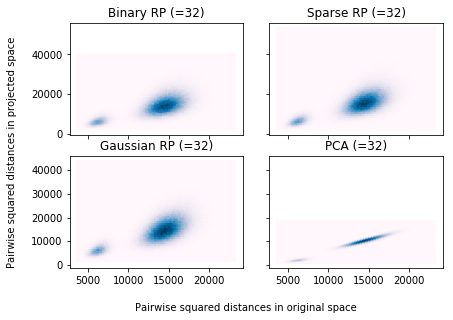

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row')
fig.tight_layout()
fig.text(0.5, -0.04, "Pairwise squared distances in original space", ha='center', va='center')
fig.text(-0.04, 0.5, "Pairwise squared distances in projected space", ha='center', va='center', rotation='vertical')

ax1.hexbin(dists, brp_dists, gridsize=100, cmap=plt.cm.PuBu)
ax1.set_title("Binary RP (=%d)"%n_components)

ax2.hexbin(dists, srp_dists, gridsize=100, cmap=plt.cm.PuBu)
ax2.set_title("Sparse RP (=%d)"%srp.n_components)

ax3.hexbin(dists, grp_dists, gridsize=100, cmap=plt.cm.PuBu)
ax3.set_title("Gaussian RP (=%d)"%grp.n_components)

ax4.hexbin(dists, pca_dists, gridsize=100, cmap=plt.cm.PuBu)
ax4.set_title("PCA (=%d)"%pca.n_components)

plt.show()

##### 2. Machine Learning Pipeline


In [11]:
from sklearn.model_selection import train_test_split
from sklearn import pipeline
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200, random_state=42)

clf = LinearSVC()
pipe_brp = pipeline.Pipeline([("dim_red", model), ("clf", clf)])
pipe_brp.set_params(dim_red__hw_accel=False)
pipe_brp.fit(X_train, y_train)
score_brp = pipe_brp.score(X_test, y_test)

pipe_srp = pipeline.Pipeline([("dim_red", srp), ("clf", clf)])
pipe_srp.set_params(dim_red__n_components=32, dim_red__density=1)
pipe_srp.fit(X_train, y_train)
score_srp = pipe_srp.score(X_test, y_test)

pipe_grp = pipeline.Pipeline([("dim_red", grp), ("clf", clf)])
pipe_grp.set_params(dim_red__n_components=32)
pipe_grp.fit(X_train, y_train)
score_grp = pipe_grp.score(X_test, y_test)

print("Binary Random Projection AUC = ", score_brp)
print("Sparse Random Projection AUC = ", score_srp)
print("Gaussian Random Projection AUC = ", score_srp)

Binary Random Projection AUC =  0.995
Sparse Random Projection AUC =  0.99
Gaussian Random Projection AUC =  0.99


When we're finished we should free all CMA buffers.

In [12]:
model.xlnk.xlnk_reset()